In [1]:
import sys
sys.path.append('../run_analyses/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# from start_run import *
from support.charting import primaryColors, fullColors, save_fig
from support.load     import loadAllData, methodParams
from support.util     import titles, order, methodTitle, modelTitle

from modelConfig      import models
from util.util        import getLeverNames

from ema_workbench.analysis import parcoords

from IPython.core import display as ICD

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
sns.set_style('white')
all_data = loadAllData()


 loading data for mordm

--------------------------------
Loading MOEA intertemporal
Loading archives from ../data/mordm/optimize/archives_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Pareto for intertemporal
Loading pareto from ../data/mordm/optimize/nondominated_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Robustness Summary intertemporal
Loading Robust Summary from ../data/mordm/robustness/summary_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
--------------------------------
Loading MOEA plannedadaptive
Loading archives from ../data/mordm/optimize/archives_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_plannedadaptive_NSGAIIHybrid_runs50_nfe100

In [3]:
robustness_scores = {}
for method in all_data.keys(): 
    robustness_scores[method] = {}
    for model in all_data[method]['robusts'].keys(): 
        robustness_scores[method][model] = []
        for idx in range(len(all_data[method]['robusts'][model])):
            print(method, model, idx)
            df = all_data[method]['robusts'][model][idx][order('outcome')]
            df = df.rename(columns={'max_P_percent': 'Fraction pollution',
                                    'reliability_percent': 'Fraction reliability', 
                                    'utility_percent': 'Fraction utility',
                                    'inertia_percent': 'Fraction inertia'})
            robustness_scores[method][model].append(df)

mordm intertemporal 0
mordm plannedadaptive 0
mordm dps 0
multi intertemporal 0
multi intertemporal 1
multi intertemporal 2
multi intertemporal 3
multi intertemporal 4
multi plannedadaptive 0
multi plannedadaptive 1
multi plannedadaptive 2
multi plannedadaptive 3
multi plannedadaptive 4
multi dps 0
multi dps 1
multi dps 2
multi dps 3
multi dps 4
moro intertemporal 0
moro plannedadaptive 0
moro dps 0


In [4]:
len(all_data['multi']['robusts']['intertemporal'])

5

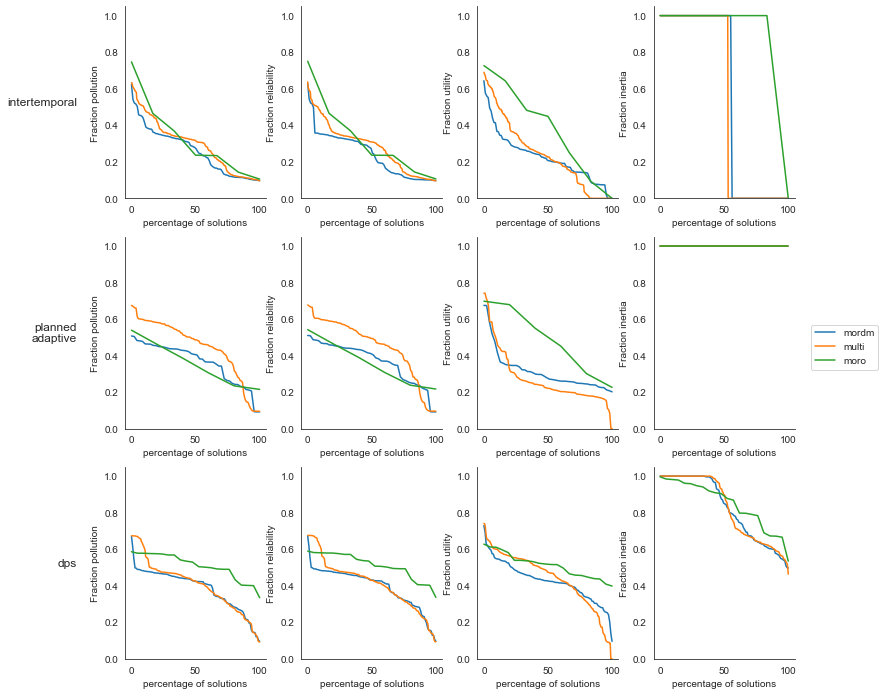

In [5]:
pfs = ['intertemporal', 'plannedadaptive', 'dps']
oois = ['Fraction pollution','Fraction reliability',
        'Fraction utility', 'Fraction inertia']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,12))
for row, pf in zip(axes, pfs):

    for ax, ooi in zip(row, oois):

        for key, value in robustness_scores.items():
            x = []

            for idx in range(len(all_data[key]['robusts'][pf])):
                x.append(robustness_scores[key][pf][idx][ooi])

            x = pd.concat(x)

            x = np.sort(x.values)[::-1]

            label = key

            ax.plot(np.linspace(0, 100, x.shape[0]),
                    x,
                    label=key)

        ax.set_ylim(bottom=0, top=1.05)

        sns.despine()

        ax.set_xlabel("percentage of solutions")
        ax.set_ylabel(ooi)

pad = 10
row_labels = ['intertemporal', 'planned\nadaptive', 'dps']
for ax, row in zip(axes[:,0], row_labels):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center right')

plt.subplots_adjust(wspace=0.25,)

# save_fig(fig, '.', 'cdfs')

plt.show()

In [6]:
all_data.keys()

dict_keys(['mordm', 'multi', 'moro'])

# Hypervolume

In [29]:
from deap.tools.indicator import hv
import pareto

In [30]:
from collections import defaultdict

robustness_scores_by_pf = defaultdict(dict)

for pf in pfs:
    scores = defaultdict(dict)
    for method, value in robustness_scores.items():
        print(method)
        x = []

        for idx in range(len(all_data[method]['robusts'][pf])):
            x.append(robustness_scores[method][pf][idx])
        
        x = pd.concat(x)
        scores[method] = x
    robustness_scores_by_pf[pf] = scores
        

mordm
multi
moro
mordm
multi
moro
mordm
multi
moro


In [33]:
# deap assumes minimization, so we flip robustness scores and
# reference point
for pf in pfs:
    for method, value in robustness_scores_by_pf[pf].items():
        if method=='multi':
            resorted = pareto.eps_sort([list(value.itertuples(False))], maximize_all=True)
            value = pd.DataFrame(resorted, columns=value.columns)
        hypv = hv.hypervolume(1-value.values, np.ones(4,))
        print(f"{pf} {method} {hypv}")

intertemporal mordm 0.04350646428985633
intertemporal multi 0.06379846381683722
intertemporal moro 0.057565819276185
plannedadaptive mordm 0.10292310042120345
plannedadaptive multi 0.14151935960939488
plannedadaptive moro 0.121525699178354
dps mordm 0.15304396528384795
dps multi 0.21588812103405527
dps moro 0.18986603569603094


# redo non dominated sort per problem formulation, across all methods

In [10]:
from ema_workbench.analysis import parcoords


In [11]:
def get_merged(pf):
    mordm = robustness_scores_by_pf[pf]['mordm']
    mordm['method'] = 'mordm'

    multi = robustness_scores_by_pf[pf]['multi']
    multi['method'] = 'multi'

    moro = robustness_scores_by_pf[pf]['moro']
    moro['method'] = 'moro'

    merged = pd.concat([mordm, multi, moro], ignore_index=True)
    return merged


def plot_front(resorted):
    cols = resorted.columns.values[0:4]
    mapper = {k:k.replace(' ', '\n') for k in cols}
    resorted = resorted.rename(columns=mapper)    
    
    limits = parcoords.get_limits(resorted.iloc[:, 0:4])
    limits.iloc[0,:] = 0
    limits.iloc[1,:] = 1

    axes = parcoords.ParallelAxes(limits, fontsize=14, rot=0)

    colors = sns.color_palette()

    grouped = resorted.groupby('method')
    
    for c, (label) in zip(colors, ['mordm', 'multi', 'moro'] ):
        data = grouped.get_group(label)
        axes.plot(data.iloc[:, 0:4], label=label, color=c, lw=1)
    axes.legend()
    
    fig = plt.gcf()
    
    return fig

## intertemporal

In [18]:
merged = get_merged('intertemporal')
merged.groupby('method').count()

,Fraction pollution,Fraction reliability,Fraction utility,Fraction inertia
method,,,,
mordm,90,90,90,90
moro,7,7,7,7
multi,291,291,291,291


In [19]:
resorted = pareto.eps_sort([list(merged.itertuples(False))], maximize_all=True, objectives=[0,1,2,3])
resorted = pd.DataFrame(resorted, columns=merged.columns)
resorted.groupby('method').count()

,Fraction pollution,Fraction reliability,Fraction utility,Fraction inertia
method,,,,
mordm,1,1,1,1
moro,7,7,7,7
multi,25,25,25,25


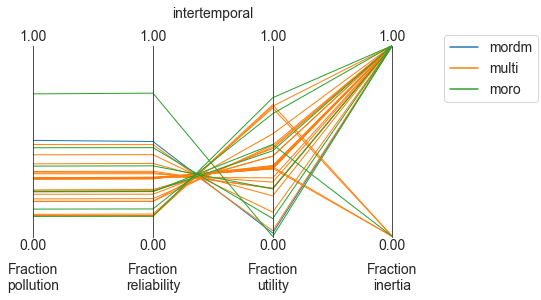

In [20]:
fig = plot_front(resorted)
fig.set_size_inches(6, 4)
fig.suptitle('intertemporal', fontsize=14, y=1.03)

save_fig(fig, './images', 'parcoords_intertemporal')

plt.show()

## planned adaptive

In [21]:
merged = get_merged('plannedadaptive')
merged.groupby('method').count()

,Fraction pollution,Fraction reliability,Fraction utility,Fraction inertia
method,,,,
mordm,48,48,48,48
moro,6,6,6,6
multi,113,113,113,113


In [23]:
resorted = pareto.eps_sort([list(merged.itertuples(False))], maximize_all=True, objectives=[0,1,2,3])
resorted = pd.DataFrame(resorted, columns=merged.columns)
resorted.groupby('method').count()

,Fraction pollution,Fraction reliability,Fraction utility,Fraction inertia
method,,,,
mordm,2,2,2,2
moro,6,6,6,6
multi,26,26,26,26


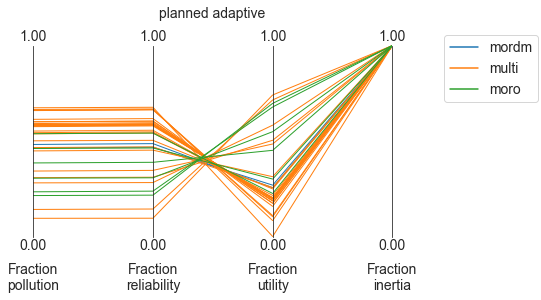

In [24]:
fig = plot_front(resorted)
fig.set_size_inches(6, 4)
fig.suptitle('planned adaptive', fontsize=14, y=1.03)

save_fig(fig, './images', 'parcoords_plannedadaptive')



plt.show()

## DPS

In [25]:
merged = get_merged('dps')
merged.groupby('method').count()

,Fraction pollution,Fraction reliability,Fraction utility,Fraction inertia
method,,,,
mordm,110,110,110,110
moro,22,22,22,22
multi,209,209,209,209


In [26]:
resorted = pareto.eps_sort([list(merged.itertuples(False))], maximize_all=True, objectives=[0,1,2,3])
resorted = pd.DataFrame(resorted, columns=merged.columns)
resorted.groupby('method').count()

,Fraction pollution,Fraction reliability,Fraction utility,Fraction inertia
method,,,,
mordm,6,6,6,6
moro,22,22,22,22
multi,58,58,58,58


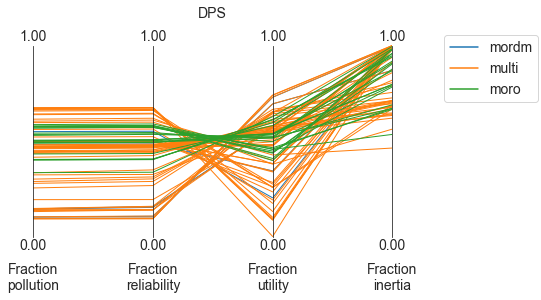

In [27]:
fig = plot_front(resorted)
fig.set_size_inches(6, 4)
fig.suptitle('DPS', fontsize=14, y=1.03)

save_fig(fig, './images', 'parcoords_dps')

plt.show()